In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import Imputer, PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC

/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
year2015 = pd.read_excel('2015 FE Guide.xlsx')
year2016 = pd.read_excel('2016 FE Guide.xlsx')
year2017 = pd.read_excel('2017 FE Guide.xlsx')
year2018 = pd.read_excel('2018 FE Guide.xlsx')

# Task 1: Linear Models

## Preprocessing

In [3]:
data = pd.concat([year2015, year2016, year2017, year2018])
data.shape

(4928, 162)

In [4]:
data = data.dropna(axis=1,how='all')
data = data.dropna(thresh=round(0.75*data.shape[0]), axis=1)
data.shape

(4928, 63)

In [5]:
target = data.loc[:,['Model Year','Comb Unrd Adj FE - Conventional Fuel']]
target.shape

(4928, 2)

In [6]:
target_train = target[target['Model Year']!=2018]
target_train = target_train.drop(columns = ['Model Year'])
print("shape of the train target:{}".format(target_train.shape))

shape of the train target:(3701, 1)


In [7]:
target_test = target[target['Model Year']==2018]
target_test = target_test.drop(columns = ['Model Year'])
print("shape of the test target:{}".format(target_test.shape))

shape of the test target:(1227, 1)


In [8]:
features = data.columns.get_values()
drop_features = ["EPA", "Rating", "FE", "Cost", "Range", "CO2", "Guzzler", "MPG", "Smog", 'Unnamed', 'costs']
index = []
for i, feature in enumerate(features):
    flag = True
    if all(name not in feature for name in drop_features):
        index.append(i)

data = data.iloc[:, index]
data.shape

(4928, 42)

In [9]:
list(data)

['Model Year',
 'Mfr Name',
 'Division',
 'Carline',
 'Verify Mfr Cd',
 'Index (Model Type Index)',
 'Eng Displ',
 '# Cyl',
 'Transmission',
 'Air Aspiration Method Desc',
 'Trans',
 'Trans Desc',
 '# Gears',
 'Lockup Torque Converter',
 'Trans Creeper Gear',
 'Drive Sys',
 'Drive Desc',
 'Max Ethanol % - Gasoline',
 'Fuel Usage  - Conventional Fuel',
 'Fuel Usage Desc - Conventional Fuel',
 'Fuel Unit - Conventional Fuel',
 'Fuel Unit Desc - Conventional Fuel',
 'Intake Valves Per Cyl',
 'Exhaust Valves Per Cyl',
 'Carline Class',
 'Carline Class Desc',
 'Calc Approach Desc',
 'Release Date',
 'Unique Label?',
 'Label Recalc?',
 'Suppressed?',
 'Police/Emerg?',
 'Cyl Deact?',
 'Var Valve Timing?',
 'Var Valve Timing Desc',
 'Var Valve Lift?',
 'Fuel Metering Sys Cd',
 'Fuel Metering Sys Desc',
 'Camless Valvetrain (Y or N)',
 'Oil Viscosity',
 'Stop/Start System (Engine Management System) Code',
 'Stop/Start System (Engine Management System)  Description']

In [10]:
# numerical features
float_data = list(data.select_dtypes(include=['float64']).columns)
# categorical features
object_data = list(data.select_dtypes(include=['object']).columns)

In [11]:
float_data

['Eng Displ', 'Max Ethanol % - Gasoline']

In [12]:
object_data

['Mfr Name',
 'Division',
 'Carline',
 'Verify Mfr Cd',
 'Transmission',
 'Air Aspiration Method Desc',
 'Trans',
 'Trans Desc',
 'Lockup Torque Converter',
 'Trans Creeper Gear',
 'Drive Sys',
 'Drive Desc',
 'Fuel Usage  - Conventional Fuel',
 'Fuel Usage Desc - Conventional Fuel',
 'Fuel Unit - Conventional Fuel',
 'Fuel Unit Desc - Conventional Fuel',
 'Carline Class Desc',
 'Calc Approach Desc',
 'Unique Label?',
 'Label Recalc?',
 'Suppressed?',
 'Police/Emerg?',
 'Cyl Deact?',
 'Var Valve Timing?',
 'Var Valve Timing Desc',
 'Var Valve Lift?',
 'Fuel Metering Sys Cd',
 'Fuel Metering Sys Desc',
 'Camless Valvetrain (Y or N)',
 'Oil Viscosity',
 'Stop/Start System (Engine Management System) Code',
 'Stop/Start System (Engine Management System)  Description']

### Fill Missing Values

In [13]:
data.isnull().sum()

Model Year                                                     0
Mfr Name                                                       0
Division                                                       0
Carline                                                        0
Verify Mfr Cd                                                  0
Index (Model Type Index)                                       0
Eng Displ                                                      0
# Cyl                                                          0
Transmission                                                   0
Air Aspiration Method Desc                                     0
Trans                                                          0
Trans Desc                                                     0
# Gears                                                        0
Lockup Torque Converter                                        0
Trans Creeper Gear                                             0
Drive Sys                

We could see that column 'Max Ethanol % - Gasoline','Unique Label?','Label Recalc?','Var Valve Timing Desc' have missing values, then we should only fill NAs in these column

In [49]:
#data[['Max Ethanol % - Gasoline','Unique Label?','Label Recalc?','Var Valve Timing Desc']]

'Max Ethanol % - Gasoline' contains numerical values; 'Unique Label?','Label Recalc?','Var Valve Timing Desc' contain string values

In [15]:
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
data[['Max Ethanol % - Gasoline']] = imputer.fit_transform(data[['Max Ethanol % - Gasoline']])

/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
data['Unique Label?'] = data['Unique Label?'].fillna(data['Unique Label?'].value_counts().index[0])
data[['Label Recalc?']] = data['Label Recalc?'].fillna(data['Label Recalc?'].value_counts().index[0])
data[['Var Valve Timing Desc']] = data['Var Valve Timing Desc'].fillna(data['Var Valve Timing Desc'].value_counts().index[0])

## Linear Model

### Split Training and Validation

In [17]:
dat = pd.get_dummies(data)

In [50]:
#display(dat)

In [19]:
dataval = dat[dat['Model Year']!=2018]
dataval = dataval.drop(columns = ['Model Year','Release Date'])
dataval.shape

(3701, 1763)

In [20]:
data_test = dat[data['Model Year']==2018]
data_test = data_test.drop(columns = ['Model Year','Release Date'])
data_test.shape

(1227, 1763)

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(dataval, target_train, test_size = 0.25, random_state = 5)

In [24]:
ridge = Ridge().fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Validation set score: {:.2f}".format(ridge.score(X_valid, y_valid)))
print("Test set score: {:.2f}".format(ridge.score(data_test, target_test)))

Training set score: 0.97
Validation set score: 0.95
Test set score: 0.94


The score is quite good, we now try to find the best parameter using gridsearch

In [25]:
param_grid = {'alpha' : np.logspace(-3,3,100)}
g_Ridge = GridSearchCV(Ridge(), param_grid, cv=10, return_train_score=True)
g_Ridge.fit(X_train, y_train)
print("Best parameter:{}".format(g_Ridge.best_params_))

/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameter:{'alpha': 0.30538555088334157}


Using the best parameter to fit the linear model

In [292]:
ridge = Ridge(alpha=0.30538555088334157).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Validation set score: {:.2f}".format(ridge.score(X_valid, y_valid)))
print("Test set score: {:.2f}".format(ridge.score(data_test, target_test)))

Training set score: 0.98
Validation set score: 0.95
Test set score: 0.95


# Task 2: Feature Engineering

## Polynomial Features

In [22]:
poly = PolynomialFeatures()
X_train_poly = poly.fit_transform(X_train)
X_train_poly.shape

(2775, 1556730)

In [24]:
ridge_poly = Ridge().fit(X_train_poly, y_train)
print("Training set score: {:.2f}".format(0ridge_poly.score(X_valid_poly, y_valid))))

Training set score: 0.99


# Task 3: Any models

* We try two regression models: DecisionTreeRegressor, RandomForestRegressor. The RandomForestRegressor model is the best.

## Decision Tree

In [29]:
param_grid = {'max_depth': range(1, dataval.shape[1], 100)}
gridDT = GridSearchCV(DecisionTreeRegressor(random_state = 0), param_grid = param_grid, cv = 10)
gridDT.fit(X_train, y_train)

/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'max_features': range(1, 1763, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
print(gridDT.best_estimator_, gridDT.best_score_)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=1601,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best') 0.9488407923547288


In [35]:
tree = DecisionTreeRegressor(random_state = 0, min_samples_split=2, max_features = 1601)
tree.fit(X_train, y_train)
print("Training set score: {:.2f}".format(tree.score(X_train, y_train)))
print("Validation set score: {:.2f}".format(tree.score(X_valid, y_valid)))
print("Test set score: {:.2f}".format(tree.score(data_test, target_test)))

Training set score: 1.00
Validation set score: 0.97
Test set score: 0.94


## Random Forest

In [34]:
param_grid = {'max_depth': range(1, dataval.shape[1], 100)}
gridRF = GridSearchCV(RandomForestRegressor(random_state = 0), param_grid = param_grid, cv = 10)
gridRF.fit(X_train, y_train)

/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479:

/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479:

/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479:

/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479:

/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479:

/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479:

/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hhanchan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479:

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'max_depth': range(1, 1763, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
print(gridRF.best_estimator_, gridRF.best_score_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=101,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False) 0.9594947149439054


In [37]:
rf = RandomForestRegressor(max_depth=101, max_features = 'auto', oob_score = False,n_estimators = 10, random_state = 0)
rf.fit(X_train, y_train)
print("Training set score: {:.2f}".format(rf.score(X_train, y_train)))
print("Validation set score: {:.2f}".format(rf.score(X_valid, y_valid)))
print("Test set score: {:.2f}".format(rf.score(data_test, target_test)))

/Users/hhanchan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Training set score: 0.99
Validation set score: 0.97
Test set score: 0.95


# Task 4: Feature Selections

## The most 10 influential features for Random Forest model are as follows
      1 Fuel Usage Desc - Conventional Fuel_Diesel, ultra low sulfur (15 ppm, maximum)
      2 Oil Viscosity_SAE 0W-20 API SN
      3 Stop/Start System (Engine Management System)  Description_Yes
      4 Index (Model Type Index)
      5 Air Aspiration Method Desc_Naturally Aspirated
      6 Stop/Start System (Engine Management System) Code_Y
      7 # Gears
      8 Trans Desc_Continuously Variable
      9 Carline Class
      10 Eng Displ

In [41]:
select_best = np.argsort(rf.feature_importances_)[-10:]
best_importances = rf.feature_importances_[select_best]

In [43]:
for rank, feature in enumerate(dataval.columns[select_best]):
    print(rank+1, feature)

1 Fuel Usage Desc - Conventional Fuel_Diesel, ultra low sulfur (15 ppm, maximum)
2 Calc Approach Desc_Derived 5-cycle label
3 Index (Model Type Index)
4 Stop/Start System (Engine Management System) Code_Y
5 Var Valve Timing Desc_Intake
6 Air Aspiration Method Desc_Naturally Aspirated
7 Trans Desc_Continuously Variable
8 # Gears
9 Carline Class
10 Eng Displ


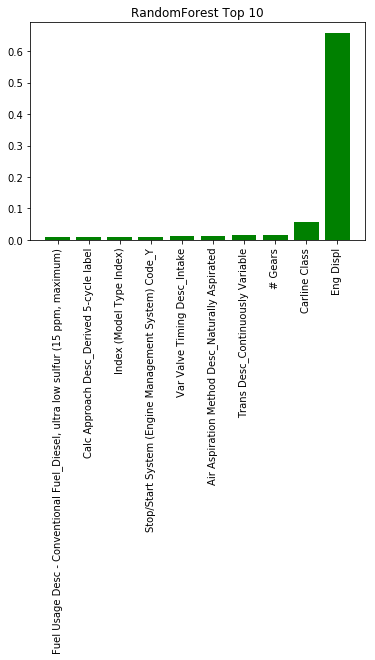

In [44]:
plt.figure()
plt.title("RandomForest Top 10")
plt.bar(range(10), best_importances, color = "g")
plt.xticks(range(10), dataval.columns[select_best], rotation = 90)
plt.show()

## The features of zero importance score could be removed without decrease in performance.
      There are 541 features of 0 importance score.

In [46]:
sum(rf.feature_importances_==0)

541

## Remove irrelevant features for random forest
    We remove 541 irrelevant features. The test score is the same as our previous score.

In [48]:
select = np.argsort(rf.feature_importances_)[541:]
X_train_select, X_valid_select = X_train.iloc[:, select], X_valid.iloc[:, select]
data_test_select = data_test.iloc[:, select]
rf = RandomForestRegressor(random_state=42).fit(X_train_select, y_train)
print("Training set score: ",rf.score(X_train_select, y_train))
print("Testing set score: ",rf.score(data_test_select, target_test))

/Users/hhanchan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Training set score:  0.9931823147882791
Testing set score:  0.9526658107119905
